In [1]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [2]:
df = pd.read_pickle('processed.pkl')

In [3]:
df.shape

(47347, 9)

In [4]:
# Join the tweet back together
def rejoin_words(row):
    words = row['stemmed']
    joined_words = (" ".join(words))
    return joined_words

In [5]:
df

,tweet_text,tidy_tweet,tidy_tweet_tokens,tokens_no_stop,no_stop_joined,islam,lemmatized,lemmatized_joined,stemmed
0,Islam is a religion full of blessings and good...,islam full blessings good deeds which also res...,"[islam, full, blessings, good, deeds, which, a...","[islam, full, blessings, good, deeds, also, re...",islam full blessings good deeds also respected...,1,"[full, blessing, good, deed, also, respect, li...",full blessing good deed also respect life well...,"[full, bless, good, deed, also, respect, life,..."
1,@ wagner_claire Religion and pity are antonyms...,pity antonyms disaster other humanity live wit...,"[pity, antonyms, disaster, other, humanity, li...","[pity, antonyms, disaster, humanity, live, wit...",pity antonyms disaster humanity live without pity,0,"[disaster, humanity, live, pity]",disaster humanity live pity,"[disast, human, live, piti]"
2,if the only reason people are on twitter is to...,only reason people twitter argue about hitler ...,"[only, reason, people, twitter, argue, about, ...","[reason, people, argue, hitler, count]",reason people argue hitler count,0,"[reason, people, argue, count]",reason people argue count,"[reason, peopl, argu, count]"
3,Religion is needed to provide a moral compass ...,needed provide moral compass those lack empathy,"[needed, provide, moral, compass, those, lack,...","[needed, provide, moral, compass, lack, empathy]",needed provide moral compass lack empathy,0,"[need, provide, moral_compass, lack, empathy]",need provide moral_compass lack empathy,"[need, provid, moral_compass, lack, empathi]"
4,plus my religion has never been 'holier' than ...,plus never been holier than regular life regul...,"[plus, never, been, holier, than, regular, lif...","[plus, never, holier, regular, life, regular, ...",plus never holier regular life regular life in...,0,"[never, holier, regular, life, regular, life, ...",never holier regular life regular life include...,"[never, holier, regular, life, regular, life, ..."
...,...,...,...,...,...,...,...,...,...
49453,Now all you have is programs of religion being...,have programs being split into separate linked...,"[have, programs, being, split, into, separate,...","[programs, split, separate, linked, cults, pro...",programs split separate linked cults prostitut...,0,"[program, split, separate, link, cult, prostit...",program split separate link cult prostitution ...,"[program, split, separ, link, cult, prostitut,..."
49454,Morality is defined by conscience rather than ...,morality defined conscience rather than,"[morality, defined, conscience, rather, than]","[morality, defined, conscience, rather]",morality defined conscience rather,0,"[morality, define, conscience, rather]",morality define conscience rather,"[moral, defin, conscienc, rather]"
49455,Persecution of vulnerable minorities can be as...,persecution vulnerable minorities much functio...,"[persecution, vulnerable, minorities, much, fu...","[persecution, vulnerable, minorities, much, fu...",persecution vulnerable minorities much functio...,0,"[persecution, vulnerable, minority, much, func...",persecution vulnerable minority much function ...,"[persecut, vulner, minor, much, function, auth..."
49456,With his clerical fascism. Though the Catholic...,with clerical fascism though catholic church b...,"[with, clerical, fascism, though, catholic, ch...","[clerical, fascism, though, catholic, church, ...",clerical fascism though catholic church becomi...,0,"[clerical, fascism, catholic, church, become, ...",clerical fascism catholic church become white ...,"[cleric, fascism, cathol, church, becom, white..."


In [19]:
df['stemmed_joined'] = df.apply(rejoin_words, axis=1)

In [20]:
vectorizer = CountVectorizer(analyzer='word',       
                             max_df=0.9, 
                             min_df=25,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

In [21]:
data_vectorized = vectorizer.fit_transform(df['stemmed_joined'])

In [22]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", round((((data_dense > 0).sum()/data_dense.size)*100),3)*100, "%")

Sparsicity:  33.0 %


In [23]:
data_dense.shape

(47347, 2012)

In [24]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=10,           # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )

In [25]:
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [26]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -2434480.0314071565
Perplexity:  1463.42526671854
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [27]:
# Define Search Param
search_params = {'n_components': [4, 7, 10, 15], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [28]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 4}
Best Log Likelihood Score:  -480771.14977709885
Model Perplexity:  1076.0893720595157


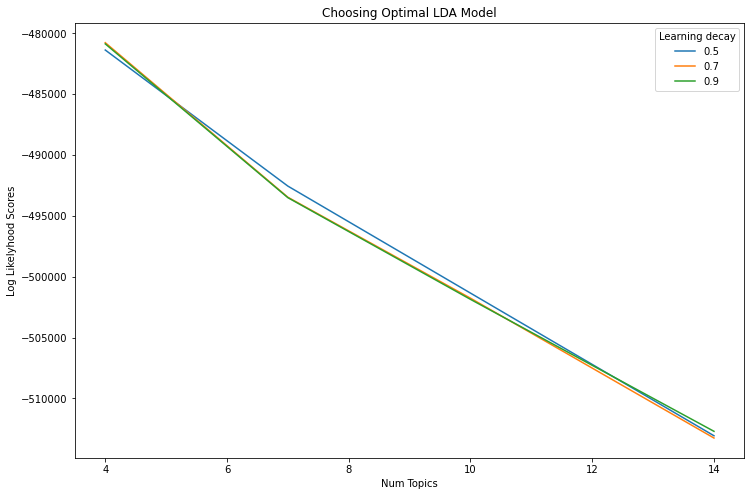

In [29]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [4, 7, 10, 14]
log_likelyhoods_5 = [round(ele) for ele in model.cv_results_['mean_test_score'][0:4]]
log_likelyhoods_7 = [round(ele) for ele in model.cv_results_['mean_test_score'][4:8]]
log_likelyhoods_9 = [round(ele) for ele in model.cv_results_['mean_test_score'][8:12]]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [30]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Tweet " + str(i) for i in range(47347)]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,dominant_topic
Tweet 0,0.030000,0.900000,0.030000,0.030000,1
Tweet 1,0.050000,0.840000,0.050000,0.060000,1
Tweet 2,0.060000,0.500000,0.050000,0.390000,1
Tweet 3,0.040000,0.890000,0.040000,0.040000,1
Tweet 4,0.040000,0.050000,0.040000,0.870000,3
Tweet 5,0.400000,0.490000,0.050000,0.050000,1
Tweet 6,0.050000,0.630000,0.270000,0.050000,1
Tweet 7,0.040000,0.040000,0.870000,0.040000,2
Tweet 8,0.040000,0.040000,0.510000,0.410000,2
Tweet 9,0.060000,0.810000,0.070000,0.060000,1


In [31]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,3,13591
1,1,11416
2,2,11228
3,0,11112


Total Tweets 47347


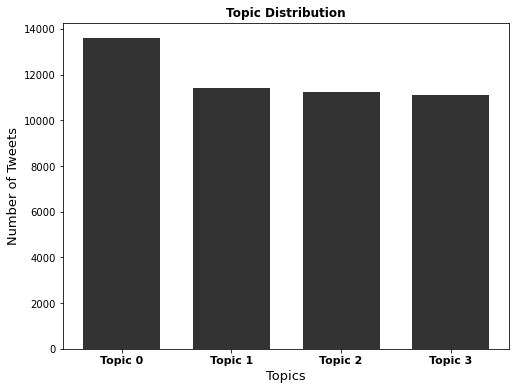

In [32]:
label = ['Topic 0', 'Topic 1', 'Topic 2', 'Topic 3']
freq = df_topic_distribution['Num Documents']
index = np.arange(len(freq))

print("Total Tweets", df_topic_distribution['Num Documents'].sum())
plt.figure(figsize=(8,6))
plt.bar(index, freq, alpha=0.8, color= 'black', width=0.7)
plt.xlabel('Topics', fontsize=13)
plt.ylabel('Number of Tweets', fontsize=13)
plt.xticks(index, label, fontsize=11, fontweight="bold") 
plt.title('Topic Distribution', fontsize=12, fontweight="bold")
plt.show()

In [33]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      269.562408 -124.803398       1        1  27.659232
2        1.782994 -295.079681       2        1  24.934058
1      220.811432 -343.832123       3        1  24.811541
0       50.533993  -76.050934       4        1  22.595170, topic_info=           Term         Freq        Total Category  logprob  loglift
169      believ  3079.000000  3079.000000  Default  30.0000  30.0000
1579        say  2704.000000  2704.000000  Default  29.0000  29.0000
284   christian  2777.000000  2777.000000  Default  28.0000  28.0000
1085       love  1944.000000  1944.000000  Default  27.0000  27.0000
419      cultur  1344.000000  1344.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
291       claim   362.169219   649.463533   Topic4  -5.3394   0.9034
1024       know   584.116118  2850.017056   Topic4  -4.8614  -0.0975
1912        use   426.417519  1294.649345   Topic4  -5.1761   0.3769
390     countri   456.194694  1736.107090   Topic4  -5.1086   0.1510
722      follow   415.713082  1269.237980   Topic4  -5.2015   0.3713

[329 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
17        1  0.009341     accus
17        3  0.037365     accus
17        4  0.952817     accus
45        2  0.991733   african
46        3  0.981575  afterlif
...     ...       ...       ...
2002      3  0.275007     wrong
2002      4  0.467051     wrong
2003      1  0.987508      year
2003      2  0.006782      year
2003      4  0.004069      year

[664 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])

In [34]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,abandon,abid,abil,abl,abolish,abort,abraham,absolut,absurd,abus,...,wrong,year,yesterday,yoga,young,youth,youtub,zealot,zionism,zionist
Topic0,12.271970,2.654357,14.650275,6.304231,5.660348,26.694477,0.260158,109.835227,55.995874,3.461683,...,607.773220,3.344617,1.979468,0.253940,5.193992,0.255970,0.256964,13.676760,48.922586,35.830104
Topic1,15.042003,17.084362,10.247424,2.267023,3.655368,122.381248,31.143923,119.349317,0.261277,173.413145,...,358.932079,0.499653,0.251917,0.254750,75.311709,0.302570,0.254851,17.170134,0.253623,0.255599
Topic2,0.312367,5.673682,40.410639,48.065289,0.263536,32.341326,125.319292,32.261979,1.742853,0.747997,...,67.424332,5.109433,5.247771,48.237376,32.968234,31.712412,0.254446,22.256848,13.570240,1.662417
Topic3,32.373660,10.587598,12.691662,99.363458,21.420747,50.582949,0.276627,43.553477,4.999996,192.377176,...,272.870369,741.046297,21.520844,0.253935,71.526065,24.729049,46.233739,1.896258,0.253551,0.251879


In [35]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,say,peopl,christian,race,think,make,nation,want,tell,wrong,atheist,know,muslim,kill,tri
Topic 1,believ,peopl,love,hate,belief,faith,good,scienc,human,life,make,person,base,reason,evil
Topic 2,christian,cultur,differ,freedom,church,practic,polit,state,peopl,chang,world,teach,power,make,use
Topic 3,right,peopl,think,thing,know,peac,race,time,good,world,countri,realli,talk,make,need


In [36]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=4, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.44  0.48  0.47  0.6 ]
 [-0.23 -0.45 -0.34  0.79]]
Perc of Variance Explained: 
 [0.01 0.36]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

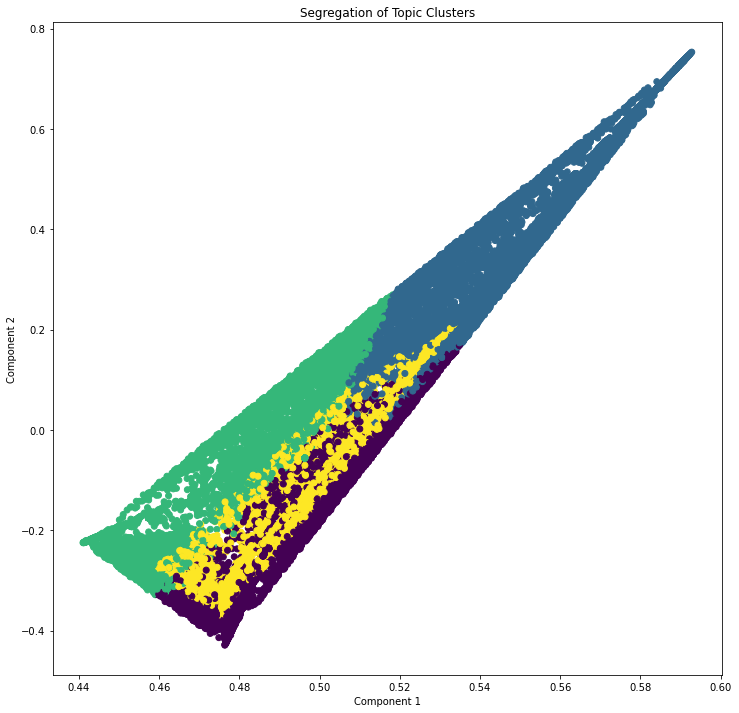

In [37]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title("Segregation of Topic Clusters", )